<a href="https://colab.research.google.com/github/TejaishwaryaGagadam/TensorFlow-ML/blob/master/Aerial_Applications_Tejaishwarya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install -q tfds-nightly tensorflow matplotlib

In [53]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split

from keras import backend as k
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
dataset, ds_info = tfds.load('deep_weeds', with_info = True)
train, test = tfds.load('deep_weeds', split = ['train[:60%]', 'train[60%:]'], as_supervised=True)

In [55]:
num_train, num_test = len(train), len(test)
print('Number of training samples {}'.format(num_train))
print("Image shape: ", ds_info.features['image'].shape)
print("Number of classes: ", ds_info.features['label'].num_classes)
print("Classes: ", ds_info.features['label'].names)
print("Feature Shape: ", ds_info.features.shape)
print("Type of features:", ds_info.features.dtype)

Number of training samples 10505
Image shape:  (256, 256, 3)
Number of classes:  9
Classes:  ['Chinee apple', 'Lantana', 'Parkinsonia', 'Parthenium', 'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake weed', 'Negative']
Feature Shape:  {'image': (256, 256, 3), 'label': ()}
Type of features: {'image': tf.uint8, 'label': tf.int64}


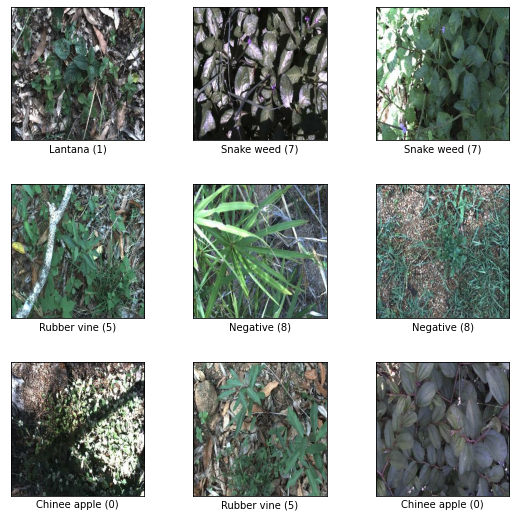

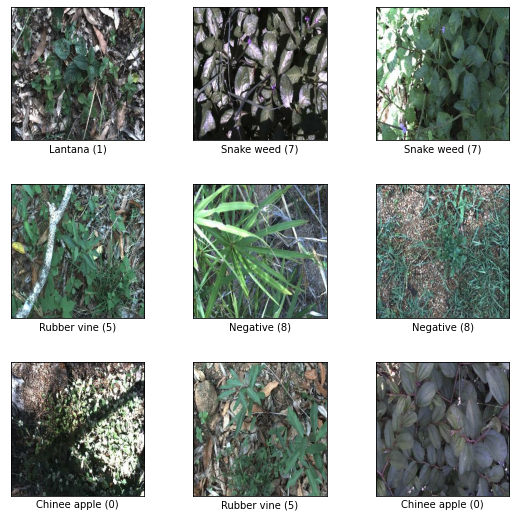

In [56]:
# before normalizing and resizing:

tfds.visualization.show_examples(train, ds_info)

In [57]:
def resize_normalize(image, label): 
  image = tf.cast(image,tf.float32)
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  image = image * 1./255 
  return image,label


def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  return image,label

In [58]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

train_scaled = train.map(resize_normalize)
test_scaled = test.map(resize_normalize)

train_augmented = train_scaled.map(augment)

In [59]:
SHUFFLE_BUFFER_SIZE = 1024
BATCH_SIZE = 32

train = train_augmented.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test = test_scaled.batch(BATCH_SIZE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

In [60]:
# global variables:

EPOCHS = 10
NUM_CLASSES = 9

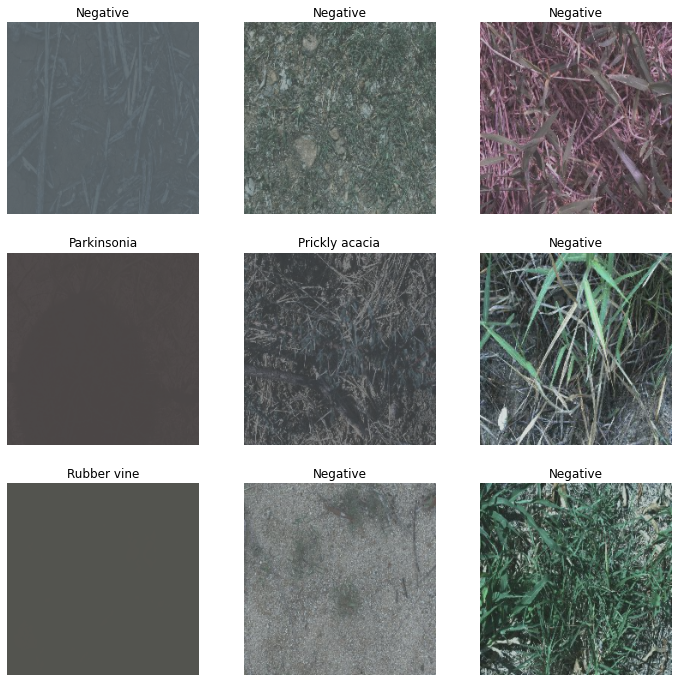

In [61]:
# after resizing and normalizing:

get_label_name = ds_info.features['label'].int2str

plt.figure(figsize=(12,12)) 
for btch in train.take(1):
  for i in range(9):
    img,lbl = btch[0][i],btch[1][i]
    plt.subplot(3,3,i+1)
    plt.title(get_label_name(lbl.numpy()))
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [62]:
train_images, train_labels = next(iter(train)) 
test_images, test_labels = next(iter(test))

# Pre-Trained model as a Feature Extractor:

We are freezing all the layers of ResNet50, which means there won't be any weight updates.

In [63]:
resnet = ResNet50(weights='imagenet',
                  input_shape=IMG_SHAPE, 
                  include_top=False) # doesnot include fully-connected layers

In [64]:
output = resnet.layers[-1].output
output = Flatten()(output)
resnet_model = Model(resnet.input, output)

resnet_model.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe119a7db38>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fe10fe0fc18>,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe11c63ad30>,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe1196a6fd0>,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activation object at 0x7fe10fe0f470>,conv1_relu,False
...,...,...,...
171,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe1122e4710>,conv5_block3_3_conv,False
172,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe112bc5a20>,conv5_block3_3_bn,False
173,<tensorflow.python.keras.layers.merge.Add object at 0x7fe112bc5278>,conv5_block3_add,False
174,<tensorflow.python.keras.layers.core.Activation object at 0x7fe112bb9320>,conv5_block3_out,False


In [65]:
resnet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [66]:
# extracting features using ResNet50

def get_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_resnet = get_features(resnet_model, train_images)
test_features_resnet = get_features(resnet_model, test_images)

print('Train Features:', train_features_resnet.shape, 
      '\nValidation Features:', test_features_resnet.shape)

Train Features: (32, 100352) 
Validation Features: (32, 100352)


In [73]:
input_shape = resnet_model.output_shape[1]

# passing the extracted features through a softmax classifier

k.clear_session()

model = Sequential()
model.add(InputLayer(input_shape = (input_shape,)))
model.add(Dense(512, activation = 'relu', input_dim = input_shape))
model.add(Dropout(0.6))
model.add(Dense(NUM_CLASSES, activation='softmax'))

opt = Adam(lr=0.1e-4)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 51,385,353
Trainable params: 51,385,353
Non-trainable params: 0
_________________________________________________________________


In [74]:
history = model.fit(x=train_features_resnet, y=train_labels,
                    validation_data=(test_features_resnet, test_labels),
                    batch_size=BATCH_SIZE,
                    epochs=30)

Epoch 1/30
1/1 [==============================] - 0s 209ms/step - loss: 3.8717 - accuracy: 0.0625 - val_loss: 3.0337 - val_accuracy: 0.0312
Epoch 2/30
1/1 [==============================] - 0s 95ms/step - loss: 2.9917 - accuracy: 0.0938 - val_loss: 2.4550 - val_accuracy: 0.0312
Epoch 3/30
1/1 [==============================] - 0s 94ms/step - loss: 2.9041 - accuracy: 0.1562 - val_loss: 2.1469 - val_accuracy: 0.4688
Epoch 4/30
1/1 [==============================] - 0s 98ms/step - loss: 2.4799 - accuracy: 0.3125 - val_loss: 2.0603 - val_accuracy: 0.4688
Epoch 5/30
1/1 [==============================] - 0s 98ms/step - loss: 2.7924 - accuracy: 0.3438 - val_loss: 2.0971 - val_accuracy: 0.4688
Epoch 6/30
1/1 [==============================] - 0s 107ms/step - loss: 2.3956 - accuracy: 0.3438 - val_loss: 2.1481 - val_accuracy: 0.4688
Epoch 7/30
1/1 [==============================] - 0s 94ms/step - loss: 2.6445 - accuracy: 0.3125 - val_loss: 2.1850 - val_accuracy: 0.4688
Epoch 8/30
1/1 [=========

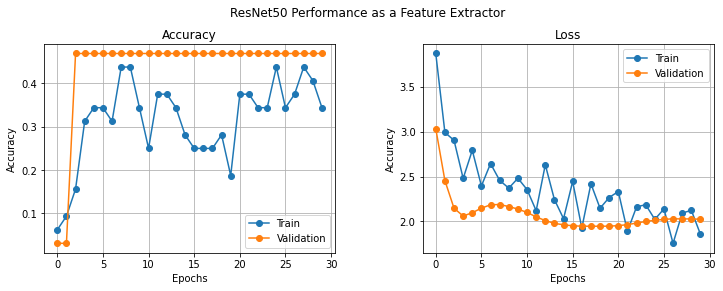

In [75]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet50 Performance as a Feature Extractor', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

ax1.plot(history.history['accuracy'],'o-')
ax1.plot(history.history['val_accuracy'],'o-')
ax1.grid()
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'])

ax2.plot(history.history['loss'],'o-')
ax2.plot(history.history['val_loss'],'o-')
ax2.grid()
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train', 'Validation']);

In [ ]:
model.save('resnet_fe.h5')

# Pre-Trained model with Fine-tuning 

Unfreezing few layers, and freezing the rest.

In [76]:
resnet_model.trainable = True
print("Number of layers in the base model: ", len(resnet_model.layers))

fine_tune_at = 150

for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  176


In [77]:
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe119a7db38>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fe10fe0fc18>,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe11c63ad30>,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe1196a6fd0>,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activation object at 0x7fe10fe0f470>,conv1_relu,False
...,...,...,...
171,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fe1122e4710>,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fe112bc5a20>,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add object at 0x7fe112bc5278>,conv5_block3_add,True
174,<tensorflow.python.keras.layers.core.Activation object at 0x7fe112bb9320>,conv5_block3_out,True


In [78]:
resnet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [92]:
k.clear_session()

model = Sequential()
model.add(resnet_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax')) 

opt = Adam(lr=0.1e-3)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 100352)            23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 74,973,065
Trainable params: 61,375,497
Non-trainable params: 13,597,568
_________________________________________________________________


In [93]:
history = model.fit(x=train_images, y=train_labels,
                    validation_data=(test_images, test_labels),
                    batch_size=BATCH_SIZE,
                    epochs=15)

Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 2.4456 - accuracy: 0.0938 - val_loss: 5.1809 - val_accuracy: 0.4688
Epoch 2/15
1/1 [==============================] - 5s 5s/step - loss: 16.3190 - accuracy: 0.4375 - val_loss: 3.7799 - val_accuracy: 0.4688
Epoch 3/15
1/1 [==============================] - 5s 5s/step - loss: 4.2465 - accuracy: 0.4062 - val_loss: 3.2245 - val_accuracy: 0.4062
Epoch 4/15
1/1 [==============================] - 5s 5s/step - loss: 3.0025 - accuracy: 0.3750 - val_loss: 3.1517 - val_accuracy: 0.4688
Epoch 5/15
1/1 [==============================] - 5s 5s/step - loss: 1.6557 - accuracy: 0.6250 - val_loss: 3.3441 - val_accuracy: 0.4688
Epoch 6/15
1/1 [==============================] - 5s 5s/step - loss: 1.8255 - accuracy: 0.5312 - val_loss: 3.3159 - val_accuracy: 0.4688
Epoch 7/15
1/1 [==============================] - 5s 5s/step - loss: 1.4990 - accuracy: 0.6875 - val_loss: 3.2566 - val_accuracy: 0.4688
Epoch 8/15
1/1 [========================

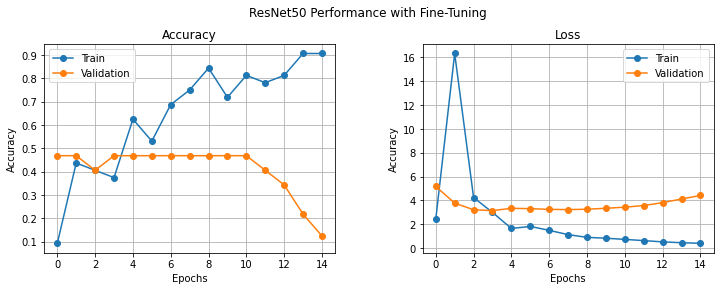

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('ResNet50 Performance with Fine-Tuning', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)


ax1.plot(history.history['accuracy'],'o-')
ax1.plot(history.history['val_accuracy'],'o-')
ax1.grid()
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'])

ax2.plot(history.history['loss'],'o-')
ax2.plot(history.history['val_loss'],'o-')
ax2.grid()
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(['Train', 'Validation']);

# Remarks:

* After loading the dataset, we normalize the data - that is, we divide the pixel values by 255 so that the range of our pixels is between [0,1], and resize the images to fit ResNet50's requirements. The raw input image's shape was (256, 256, 3) and we transform that to (224, 224, 3). 
* We also perform data augmentation on the train set, that helps models understand the images better and increases the size of the data. Augmentation also acts as a regularization method. 
* We shuffle the data, and process them in batches. As TensorFlow v2's new API feature - we use *prefetch* to load the next batch and keep it on stantby in the pipeline. This proved to improve the runtime of the model.




1. **ResNet50 as a Feature Extractor:**
  - We freeze all the layers of the pre-trained network, so that the weights are not updated during training. We use the weights of 'imagenet' dataset. 
  - After extracting the features of the train and test set of deep_weeds dataset, we run it through a classifier that we added on top of our pre-trained network. 
  - We can see that the train accuracy and test accuracy are comparable, which means the model isn't overfitting.
  - We can improve the model's performance by adding more data augmentation techniques, tuning the hyperparameters like learning_rate, dropout value. 

2. **ResNet50 with Fine Tuning:**
  - We unfreeze all the layers of the pre-trained network, that is all the ResNet50's layers are set to *trainable* and then we experiment by freezing the bottom most layers.
  - However, we can clearly observe that this model is overfitting. The test loss is much higher than the train loss, and test accuracy remains constant while the train accuracy increases. 
  - While training I tuned the following hyperparameters - learning_rate, changing the number of frozen layers, added kernel_regularizers to fully connected layers, added batch normalization layer, added dropout layer with different values. Adding more data augmentation along with trying different combinations of hyperparameters (like a grid search) would yield a better result. 